# Case 3: Recheio Customer Data Enrichment & Recommendation Engine

## Overview
This case study focuses on enriching Recheio Cash & Carry’s customer dataset to deliver more relevant product recommendations across digital channels such as the website, mobile app, POS, and contact center. The project combines customer segmentation and association rule mining to develop systems like **Smart Baskets** and **Did You Forget**, enhancing customer experience and increasing Recheio’s share in total customer purchases.

## Business Problem
- Recheio serves two distinct segments (HoReCa and Traditional Retail), each with unique needs.  
- Customer relationship and loyalty are heavily dependent on personalized and insightful interactions.  
- Current data systems are fragmented, limiting the ability to generate impactful recommendations.  
- There is a need to increase **Recheio’s share of wallet** by becoming more relevant in each customer’s purchasing behavior.

## Objective
- **Enrich the customer dataset** with relevant external or engineered information.  
- **Segment customers** and **Generate association rules** to recommend products using logic like **Smart Baskets** and **Did You Forget**.  
- **Validate the recommendations** using offline evaluation metrics.

---

**This notebook was developed by:**  
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564


# 1.Import Libraries

In [2]:
import calendar
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [3]:
clients = pd.read_excel("Case3_Recheio_2025.xlsx",sheet_name=0, header=1)
clients = clients.iloc[:, 1:]
clients

,Client ID,ZIP Code,ID Client Type
0,210100002,4049,NaN
1,210100003,4000,NaN
2,210100004,4149,NaN
3,210100005,4100,Hotelaria
4,210100006,4405,NaN
...,...,...,...
6457,210199921,4750,NaN
6458,210199922,3004,NaN
6459,210199928,4100,NaN
6460,210199937,4520,NaN


In [4]:
products = pd.read_excel("Case3_Recheio_2025.xlsx",sheet_name=1,header=1)
products = products.iloc[:, 1:]
products

,ID Product,Product Description,ID Product Category
0,224780,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS
1,276806,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS
2,276809,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS
3,277674,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS
4,277917,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS
...,...,...,...
4578,962871,PETIT GATEAU CHOCOLATE PRETO ROLO 16X80G,BOLOS E SOBREMESAS INDIVIDUAIS
4579,863666,TOSTAS AMANH C/PASSAS 150GR,PRODUTOS DE PADARIA
4580,975316,POLVO FRIBO T7 FLÔR DE 500/800 KG,CEFALÓPODES
4581,617063,NATAS PARMALAT P/CULIN. 1 LT,NATAS


In [5]:
transactions = pd.read_excel("Case3_Recheio_2025.xlsx",sheet_name=2, header=1)
transactions = transactions.iloc[:, 1:]
transactions

,Date,Client ID,ID Product
0,2022-01-02,210100281,224780
1,2022-01-02,210100281,276806
2,2022-01-02,210100281,276809
3,2022-01-02,210100281,277674
4,2022-01-02,210100281,277917
...,...,...,...
884094,2022-12-31,210106386,949447
884095,2022-12-31,210106386,954062
884096,2022-12-31,210199916,106702
884097,2022-12-31,210199916,906800


### EDA

In [6]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6462 entries, 0 to 6461
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Client ID       6462 non-null   int64 
 1   ZIP Code        6462 non-null   int64 
 2   ID Client Type  680 non-null    object
dtypes: int64(2), object(1)
memory usage: 151.6+ KB


In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4583 entries, 0 to 4582
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID Product           4583 non-null   int64 
 1   Product Description  4583 non-null   object
 2   ID Product Category  4583 non-null   object
dtypes: int64(1), object(2)
memory usage: 107.5+ KB


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884099 entries, 0 to 884098
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        884099 non-null  datetime64[ns]
 1   Client ID   884099 non-null  int64         
 2   ID Product  884099 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 20.2 MB


### Verify Duplicates

In [9]:
client_duplicates = clients.duplicated(subset=['Client ID']).sum()
print(f"Number of duplicate Client IDs: {client_duplicates}")

product_id_duplicates = products.duplicated(subset=['ID Product']).sum()
print(f"Number of duplicate Product IDs: {product_id_duplicates}")

product_desc_duplicates = products.duplicated(subset=['Product Description']).sum()
print(f"Number of duplicate Product Descriptions: {product_desc_duplicates}")

Number of duplicate Client IDs: 0
Number of duplicate Product IDs: 0
Number of duplicate Product Descriptions: 10


Check if the Duplicate Product Description correspond to  the same Product Categories

In [10]:
duplicate_descriptions = products[products.duplicated(subset=['Product Description'], keep=False)]
category_check = duplicate_descriptions.groupby('Product Description')['ID Product Category'].nunique().reset_index()
conflicting_descriptions = category_check[category_check['ID Product Category'] > 1]

if not conflicting_descriptions.empty:
    print("Product Descriptions with conflicting categories:")
    conflict_rows = products[products['Product Description'].isin(conflicting_descriptions['Product Description'])]
    print(conflict_rows)
else:
    print("All duplicate Product Descriptions have the same Product Category.")

All duplicate Product Descriptions have the same Product Category.


### Number of Transactions Over Time


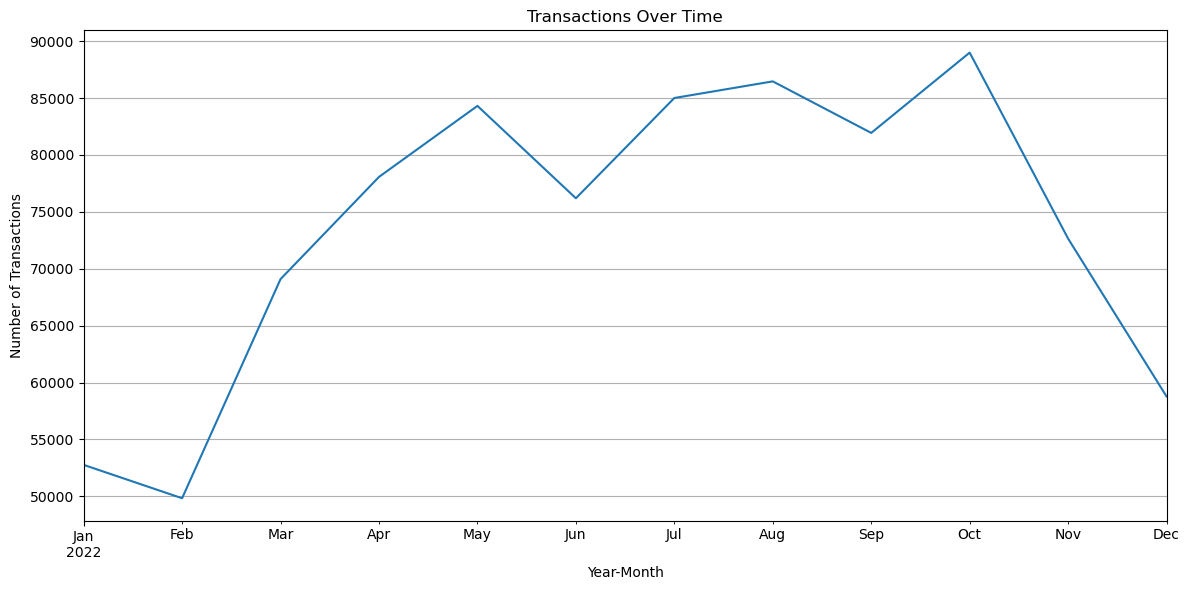

In [11]:
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions['YearMonth'] = transactions['Date'].dt.to_period('M')
tx_by_month = transactions.groupby('YearMonth').size()

tx_by_month.plot(kind='line', figsize=(12,6), title='Transactions Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

### Best-Selling Products

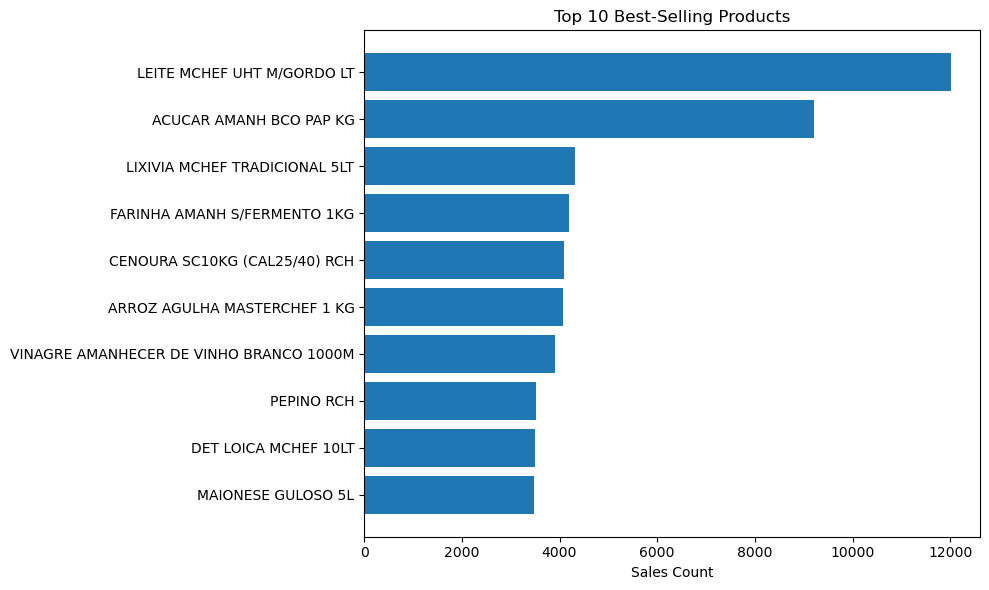

In [12]:
top_products = transactions['ID Product'].value_counts().head(10).reset_index()
top_products.columns = ['ID Product', 'Sales Count']
top_products = top_products.merge(products, on='ID Product')

plt.figure(figsize=(10, 6))
plt.barh(top_products['Product Description'], top_products['Sales Count'])
plt.xlabel('Sales Count')
plt.title('Top 10 Best-Selling Products')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Client Type

C:\Users\gonca\AppData\Local\Temp\ipykernel_4740\3764846086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=client_types.index, y=client_types.values, palette='Greens_d')


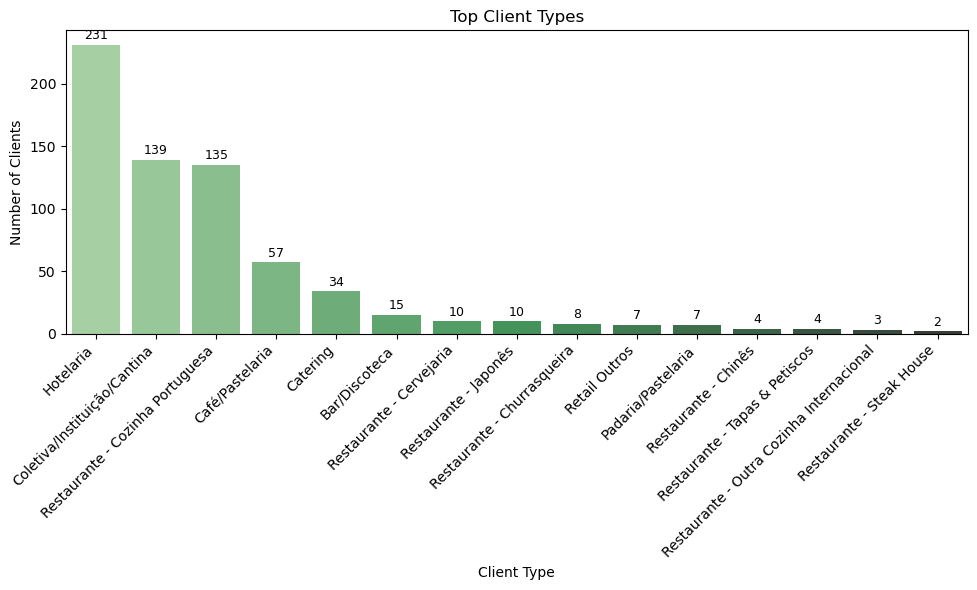

In [13]:
top_n = 15
client_types = clients['ID Client Type'].value_counts().nlargest(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=client_types.index, y=client_types.values, palette='Greens_d')
plt.title('Top Client Types')
plt.xlabel('Client Type')
plt.ylabel('Number of Clients')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, v in enumerate(client_types.values):
    plt.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=9)

plt.show()

Number of unique product categories

In [14]:
category_counts = products['ID Product Category'].value_counts()

print(f"Number of unique product categories: {products['ID Product Category'].nunique()}")
print(category_counts)

Number of unique product categories: 268
ID Product Category
VINHOS TINTOS                 175
CONSERVAS VEGETAIS            172
MOLHOS                        159
VINHOS BRANCOS                148
LEGUMES FRESCOS               133
                             ... 
FERMENTO FRESCO                 1
MORTADELA                       1
LEITE EM PÓ                     1
DOCES E CREMES PARA BARRAR      1
SAZONAIS                        1
Name: count, Length: 268, dtype: int64


### Merge the Dataset

In [15]:
transactions_clients = transactions.merge(clients, on='Client ID', how='left')
data = transactions_clients.merge(products, on='ID Product', how='left')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884099 entries, 0 to 884098
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 884099 non-null  datetime64[ns]
 1   Client ID            884099 non-null  int64         
 2   ID Product           884099 non-null  int64         
 3   YearMonth            884099 non-null  period[M]     
 4   ZIP Code             884099 non-null  int64         
 5   ID Client Type       389817 non-null  object        
 6   Product Description  884099 non-null  object        
 7   ID Product Category  884099 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3), period[M](1)
memory usage: 54.0+ MB
None


In [16]:
data.head(5)

,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category
0,2022-01-02,210100281,224780,2022-01,4400,Café/Pastelaria,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS
1,2022-01-02,210100281,276806,2022-01,4400,Café/Pastelaria,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS
2,2022-01-02,210100281,276809,2022-01,4400,Café/Pastelaria,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS
3,2022-01-02,210100281,277674,2022-01,4400,Café/Pastelaria,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS
4,2022-01-02,210100281,277917,2022-01,4400,Café/Pastelaria,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS


# **Feature Engeneering**

RFM Analysis

In [17]:
test_data = data.copy()
snapshot_date = test_data['Date'].max() + pd.Timedelta(days=1)

rfm = test_data.groupby('Client ID').agg(
    Recency=('Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('Date', 'nunique'),
    Monetary=('ID Product', 'count')
).reset_index()

test_data = test_data.merge(rfm, on='Client ID', how='left')

Weekly Purchase Percentage Features (aka vê a percentagem de produtos que compras na segunda, na terça, etc)

In [18]:
test_data['Weekday'] = test_data['Date'].dt.weekday
weekday_counts = test_data.groupby(['Client ID', 'Weekday']).size().reset_index(name='Count')
total_counts = weekday_counts.groupby('Client ID')['Count'].sum().reset_index(name='Total')
weekday_counts = weekday_counts.merge(total_counts, on='Client ID')
weekday_counts['Percentage'] = weekday_counts['Count'] / weekday_counts['Total']
weekday_pivot = weekday_counts.pivot(index='Client ID', columns='Weekday', values='Percentage').fillna(0)
weekday_pivot.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
test_data = test_data.merge(weekday_pivot, on='Client ID', how='left')

Average Number of Products Bought per Week and Average Number of Products per Purchase

In [19]:
test_data['YearWeek'] = test_data['Date'].dt.strftime('%Y-%U')

total_products = test_data.groupby('Client ID')['ID Product'].count().reset_index(name='Total_Products')
unique_weeks = test_data.groupby('Client ID')['YearWeek'].nunique().reset_index(name='Unique_Weeks')
unique_days = test_data.groupby('Client ID')['Date'].nunique().reset_index(name='Unique_Days')

agg_data = total_products.merge(unique_weeks, on='Client ID').merge(unique_days, on='Client ID')
agg_data['Avg_Products_Per_Week'] = agg_data['Total_Products'] / agg_data['Unique_Weeks']
agg_data['Avg_Products_Per_Purchase'] = agg_data['Total_Products'] / agg_data['Unique_Days']

test_data = test_data.merge(agg_data[['Client ID', 'Avg_Products_Per_Week', 'Avg_Products_Per_Purchase']], on='Client ID', how='left')

See the unique zip codes and their respective counts

In [20]:
zip_counts = test_data['ZIP Code'].value_counts().reset_index()
zip_counts.columns = ['ZIP Code', 'Count']
zip_counts = zip_counts.sort_values('ZIP Code', ascending=True)
print(zip_counts)

     ZIP Code  Count
121      1100      2
109      1349     61
123      2414      1
116      2420     13
119      2485      8
..        ...    ...
92       5150    245
83       5370    392
88       5400    323
107      6300     64
106      6420     76

[124 rows x 2 columns]


Zip Code into Region

In [21]:
def map_region(zip_code):
    if 1000 <= zip_code <= 1999:
        return 'Lisboa'
    elif 2000 <= zip_code <= 3999:
        return 'Centro'
    elif 4000 <= zip_code <= 4999:
        return 'Porto'
    elif 5000 <= zip_code <= 5999:
        return 'Norte'
    elif 6000 <= zip_code <= 6999:
        return 'Sul'
    elif 8000 <= zip_code <= 8999:
        return 'Algarve'
    elif 9000 <= zip_code <= 9999:
        return 'Ilhas'
    else:
        return 'Outros'

test_data['Region'] = test_data['ZIP Code'].apply(map_region)
region_dummies = pd.get_dummies(test_data['Region'], prefix='Region')
test_data = pd.concat([test_data, region_dummies], axis=1)
region_cols = [col for col in test_data.columns if col.startswith('Region_')]
test_data[region_cols] = test_data[region_cols].astype(int)

Most Relevant Categories

In [22]:
category_counts = test_data['ID Product Category'].value_counts().reset_index()
category_counts.columns = ['ID Product Category', 'Count']
category_counts['Percentage'] = category_counts['Count'] / category_counts['Count'].sum()
category_counts['Cumulative_Percentage'] = category_counts['Percentage'].cumsum()
top_categories = category_counts[category_counts['Cumulative_Percentage'] <= 0.80]

print(top_categories)
print(f"Number of categories covering 80% of purchases: {top_categories.shape[0]}")

   ID Product Category  Count  Percentage  Cumulative_Percentage
0      LEGUMES FRESCOS  62717    0.070939               0.070939
1   CONSERVAS VEGETAIS  50190    0.056770               0.127709
2       FRUTAS FRESCAS  48627    0.055002               0.182710
3               MOLHOS  32396    0.036643               0.219353
4              4A GAMA  19502    0.022059               0.241412
..                 ...    ...         ...                    ...
60               LUVAS   4020    0.004547               0.781721
61       QUEIJOS PRATO   3924    0.004438               0.786160
62      VINHO DO PORTO   3741    0.004231               0.790391
63    CERVEJAS BRANCAS   3731    0.004220               0.794611
64    NÃO CARBONATADOS   3698    0.004183               0.798794

[65 rows x 4 columns]
Number of categories covering 80% of purchases: 65


In [23]:
top_category_list = top_categories['ID Product Category'].tolist()
print(top_category_list)

['LEGUMES FRESCOS', 'CONSERVAS VEGETAIS', 'FRUTAS FRESCAS', 'MOLHOS', '4A GAMA', 'ÓLEOS', 'ARROZ', 'ESPECIARIAS', 'LEITE UHT REGULAR', 'IOGURTES', 'AÇÚCAR', 'NATAS', 'FARINHAS', 'VINHOS BRANCOS', 'HORTÍCOLAS CONSERVAÇÃO', 'ÁGUAS LISAS', 'MANTEIGAS', 'CARBONATADOS', 'SOBREMESAS', 'MASSAS', 'AZEITES', 'PADARIA', 'OVOS GAIOLA', 'FRUTAS EM CONSERVA', 'SAL', 'PASTELARIA', 'VINAGRES', 'FIAMBRES', 'MEL E DOCES', 'GELADOS CATERING', 'VEGETAIS DE FOLHA E CRUCÍFEROS', 'VINHOS TINTOS', 'PRODUTOS DE PADARIA', 'CONSERVAS ATUM', 'OVOS PROCESSADOS', 'FRUTOS SECOS', 'AVES / CAÇA / COELHO', 'PESCADO AQUICULTURA', 'BOVINO', 'OUTROS QUEIJOS ESTRANGEIROS', 'BATATA', 'PRODUTOS PARA DOÇARIA', 'ACESSORIOS TRANSPORTE', 'DETERGENTE LOIÇA', 'SUINO', 'BOLACHAS', 'CREMES VEGETAIS', 'CHOCOLATE', 'SACOS LIXO', 'FLAMENGO', 'CONSERVAÇÃO DE ALIMENTOS', 'FRUTAS', 'BACON', 'BOLOS E SOBREMESAS INDIVIDUAIS', 'LEGUMINOSAS E GRÃOS', 'CONDIMENTOS', 'LIXÍVIAS TRADICIONAIS', 'SALGADOS / SNACKS E ENTRADAS', 'ÁGUAS COM GÁS', 'QU

Aggregate Categories

In [24]:
main_categories = ['LEGUMES FRESCOS', 'CONSERVAS VEGETAIS', 'FRUTAS FRESCAS', 'MOLHOS', '4A GAMA', 
                   'ÓLEOS', 'ARROZ', 'ESPECIARIAS', 'LEITE UHT REGULAR', 'IOGURTES', 'AÇÚCAR', 'NATAS', 
                   'FARINHAS', 'VINHOS BRANCOS', 'HORTÍCOLAS CONSERVAÇÃO', 'ÁGUAS LISAS', 'MANTEIGAS', 
                   'CARBONATADOS', 'SOBREMESAS', 'MASSAS', 'AZEITES', 'PADARIA', 'OVOS GAIOLA', 
                   'FRUTAS EM CONSERVA', 'SAL', 'PASTELARIA', 'VINAGRES', 'FIAMBRES', 'MEL E DOCES', 
                   'GELADOS CATERING', 'VEGETAIS DE FOLHA E CRUCÍFEROS', 'VINHOS TINTOS', 
                   'PRODUTOS DE PADARIA', 'CONSERVAS ATUM', 'OVOS PROCESSADOS', 'FRUTOS SECOS', 
                   'AVES / CAÇA / COELHO', 'PESCADO AQUICULTURA', 'BOVINO', 'OUTROS QUEIJOS ESTRANGEIROS', 
                   'BATATA', 'PRODUTOS PARA DOÇARIA', 'ACESSORIOS TRANSPORTE', 'DETERGENTE LOIÇA', 'SUINO', 
                   'BOLACHAS', 'CREMES VEGETAIS', 'CHOCOLATE', 'SACOS LIXO', 'FLAMENGO', 
                   'CONSERVAÇÃO DE ALIMENTOS', 'FRUTAS', 'BACON', 'BOLOS E SOBREMESAS INDIVIDUAIS', 
                   'LEGUMINOSAS E GRÃOS', 'CONDIMENTOS', 'LIXÍVIAS TRADICIONAIS', 
                   'SALGADOS / SNACKS E ENTRADAS', 'ÁGUAS COM GÁS', 'QUEIJOS FRESCOS', 'LUVAS', 
                   'QUEIJOS PRATO', 'VINHO DO PORTO', 'CERVEJAS BRANCAS', 'NÃO CARBONATADOS']

category_mapping = {
    'LEGUMES FRESCOS': 'Frescos',
    'FRUTAS FRESCAS': 'Frescos',
    'VEGETAIS DE FOLHA E CRUCÍFEROS': 'Frescos',
    '4A GAMA': 'Frescos',
    'FRUTAS': 'Frescos',
    'HORTÍCOLAS CONSERVAÇÃO': 'Frescos',
    
    'CONSERVAS VEGETAIS': 'Conservas',
    'FRUTAS EM CONSERVA': 'Conservas',
    'CONSERVAS ATUM': 'Conservas',
    
    'PADARIA': 'Padaria e Pastelaria',
    'PASTELARIA': 'Padaria e Pastelaria',
    'PRODUTOS DE PADARIA': 'Padaria e Pastelaria',
    'BOLOS E SOBREMESAS INDIVIDUAIS': 'Padaria e Pastelaria',
    
    'AVES / CAÇA / COELHO': 'Carnes e Peixes',
    'PESCADO AQUICULTURA': 'Carnes e Peixes',
    'BOVINO': 'Carnes e Peixes',
    'SUINO': 'Carnes e Peixes',
    'BACON': 'Carnes e Peixes',
    
    'LEITE UHT REGULAR': 'Laticínios',
    'IOGURTES': 'Laticínios',
    'MANTEIGAS': 'Laticínios',
    'NATAS': 'Laticínios',
    'CREMES VEGETAIS': 'Laticínios',
    'OUTROS QUEIJOS ESTRANGEIROS': 'Laticínios',
    'QUEIJOS FRESCOS': 'Laticínios',
    'QUEIJOS PRATO': 'Laticínios',
    'FLAMENGO': 'Laticínios',
    
    'MOLHOS': 'Mercearia Seca',
    'ÓLEOS': 'Mercearia Seca',
    'ARROZ': 'Mercearia Seca',
    'ESPECIARIAS': 'Mercearia Seca',
    'AÇÚCAR': 'Mercearia Seca',
    'FARINHAS': 'Mercearia Seca',
    'MASSAS': 'Mercearia Seca',
    'AZEITES': 'Mercearia Seca',
    'SAL': 'Mercearia Seca',
    'VINAGRES': 'Mercearia Seca',
    'MEL E DOCES': 'Mercearia Seca',
    'LEGUMINOSAS E GRÃOS': 'Mercearia Seca',
    'CONDIMENTOS': 'Mercearia Seca',
    
    'VINHOS BRANCOS': 'Bebidas',
    'VINHOS TINTOS': 'Bebidas',
    'VINHO DO PORTO': 'Bebidas',
    'ÁGUAS LISAS': 'Bebidas',
    'ÁGUAS COM GÁS': 'Bebidas',
    'CARBONATADOS': 'Bebidas',
    'NÃO CARBONATADOS': 'Bebidas',
    'CERVEJAS BRANCAS': 'Bebidas',
    
    'SOBREMESAS': 'Snacks e Doces',
    'GELADOS CATERING': 'Snacks e Doces',
    'SALGADOS / SNACKS E ENTRADAS': 'Snacks e Doces',
    'BOLACHAS': 'Snacks e Doces',
    'CHOCOLATE': 'Snacks e Doces',
    
    'ACESSORIOS TRANSPORTE': 'Não Alimentar',
    'SACOS LIXO': 'Não Alimentar',
    'DETERGENTE LOIÇA': 'Não Alimentar',
    'LIXÍVIAS TRADICIONAIS': 'Não Alimentar',
    'LUVAS': 'Não Alimentar',
    'CONSERVAÇÃO DE ALIMENTOS': 'Não Alimentar'
}

for cat in main_categories:
    if cat not in category_mapping:
        category_mapping[cat] = 'Outros'

test_data['Macro_Category'] = test_data['ID Product Category'].apply(
    lambda x: category_mapping.get(x, 'Outros')
)

macro_counts = test_data.groupby(['Client ID', 'Macro_Category']).size().reset_index(name='Count')
total_counts = macro_counts.groupby('Client ID')['Count'].sum().reset_index(name='Total')
macro_counts = macro_counts.merge(total_counts, on='Client ID')
macro_counts['Percentage'] = macro_counts['Count'] / macro_counts['Total']
macro_pivot = macro_counts.pivot(index='Client ID', columns='Macro_Category', values='Percentage').fillna(0)

print(macro_pivot.head())
test_data = test_data.merge(macro_pivot, on='Client ID', how='left')

Macro_Category   Bebidas  Carnes e Peixes  Conservas   Frescos  Laticínios  \
Client ID                                                                    
210100005       0.000000         0.000000   0.024390  0.573171    0.048780   
210100012       0.000000         0.000000   0.000000  0.000000    0.000000   
210100033       0.000000         0.033816   0.033011  0.440419    0.074879   
210100051       0.024890         0.000000   0.124451  0.000000    0.311859   
210100096       0.009259         0.000000   0.069444  0.023148    0.076389   

Macro_Category  Mercearia Seca  Não Alimentar    Outros  Padaria e Pastelaria  \
Client ID                                                                       
210100005             0.121951       0.000000  0.231707              0.000000   
210100012             0.000000       0.666667  0.333333              0.000000   
210100033             0.185990       0.000000  0.209340              0.000000   
210100051             0.314788       0.095168  0

RFM Distributions

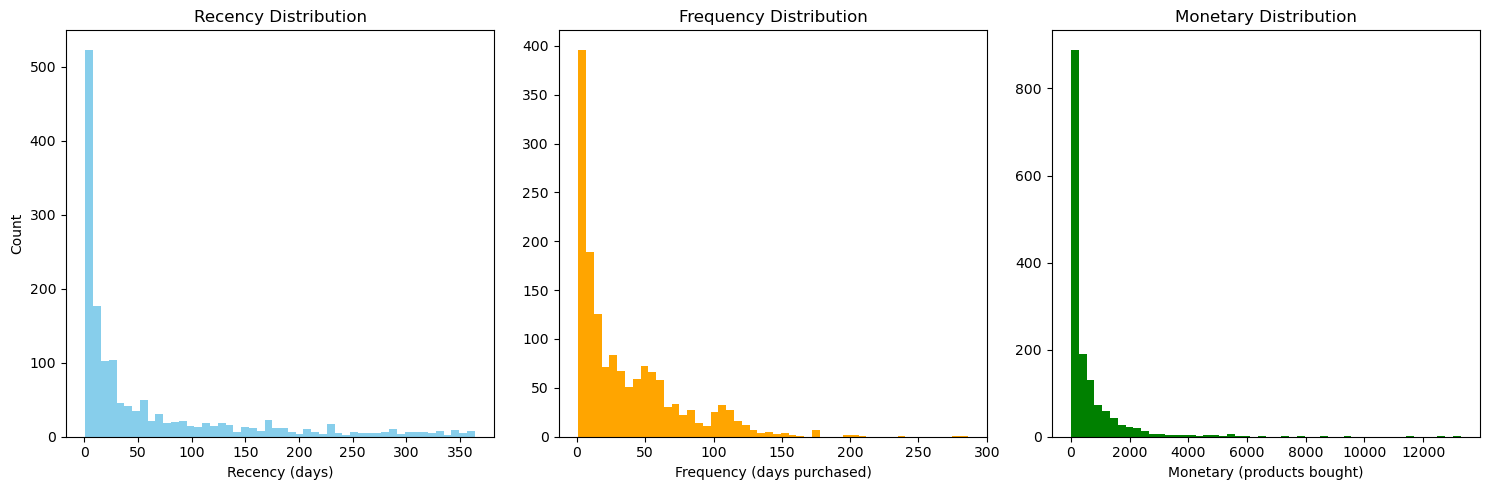

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(test_data.drop_duplicates('Client ID')['Recency'], bins=50, color='skyblue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Count')

axes[1].hist(test_data.drop_duplicates('Client ID')['Frequency'], bins=50, color='orange')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Frequency (days purchased)')

axes[2].hist(test_data.drop_duplicates('Client ID')['Monetary'], bins=50, color='green')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Monetary (products bought)')

plt.tight_layout()
plt.show()

In [26]:
test_data

,Date,Client ID,ID Product,YearMonth,ZIP Code,ID Client Type,Product Description,ID Product Category,Recency,Frequency,...,Bebidas,Carnes e Peixes,Conservas,Frescos,Laticínios,Mercearia Seca,Não Alimentar,Outros,Padaria e Pastelaria,Snacks e Doces
0,2022-01-02,210100281,224780,2022-01,4400,Café/Pastelaria,FARINHA ESPIGA AMIDO MILHO LUS.2KG,FARINHAS,1,106,...,0.006416,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428
1,2022-01-02,210100281,276806,2022-01,4400,Café/Pastelaria,LARANJA CAL7 (67/76) RCH,FRUTAS FRESCAS,1,106,...,0.006416,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428
2,2022-01-02,210100281,276809,2022-01,4400,Café/Pastelaria,LIMAO CAL 3/4 RCH,FRUTAS FRESCAS,1,106,...,0.006416,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428
3,2022-01-02,210100281,277674,2022-01,4400,Café/Pastelaria,COGUMELO BRANCO MÉDIO RCH,LEGUMES FRESCOS,1,106,...,0.006416,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428
4,2022-01-02,210100281,277917,2022-01,4400,Café/Pastelaria,TOMATE BB 67/82 1CAM RCH,LEGUMES FRESCOS,1,106,...,0.006416,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884094,2022-12-31,210106386,949447,2022-12,4000,Hotelaria,"BATATA WEDGES C PELE ECOFROST CG 2,5 KG",BATATA,1,7,...,0.064706,0.041176,0.094118,0.147059,0.052941,0.229412,0.047059,0.300000,0.011765,0.011765
884095,2022-12-31,210106386,954062,2022-12,4000,Hotelaria,FIAMBRE FATIADO CASA PORTUGUESA 750G,FIAMBRES,1,7,...,0.064706,0.041176,0.094118,0.147059,0.052941,0.229412,0.047059,0.300000,0.011765,0.011765
884096,2022-12-31,210199916,106702,2022-12,4480,NaN,MOSTARDA DONA SARAH 950GR,MOLHOS,1,87,...,0.057063,0.050104,0.178149,0.052192,0.096033,0.171886,0.000000,0.351427,0.000000,0.043145
884097,2022-12-31,210199916,906800,2022-12,4480,NaN,MOLHO INGLES UNCLE THOMAS 1 LT,MOLHOS,1,87,...,0.057063,0.050104,0.178149,0.052192,0.096033,0.171886,0.000000,0.351427,0.000000,0.043145


Outliers Check

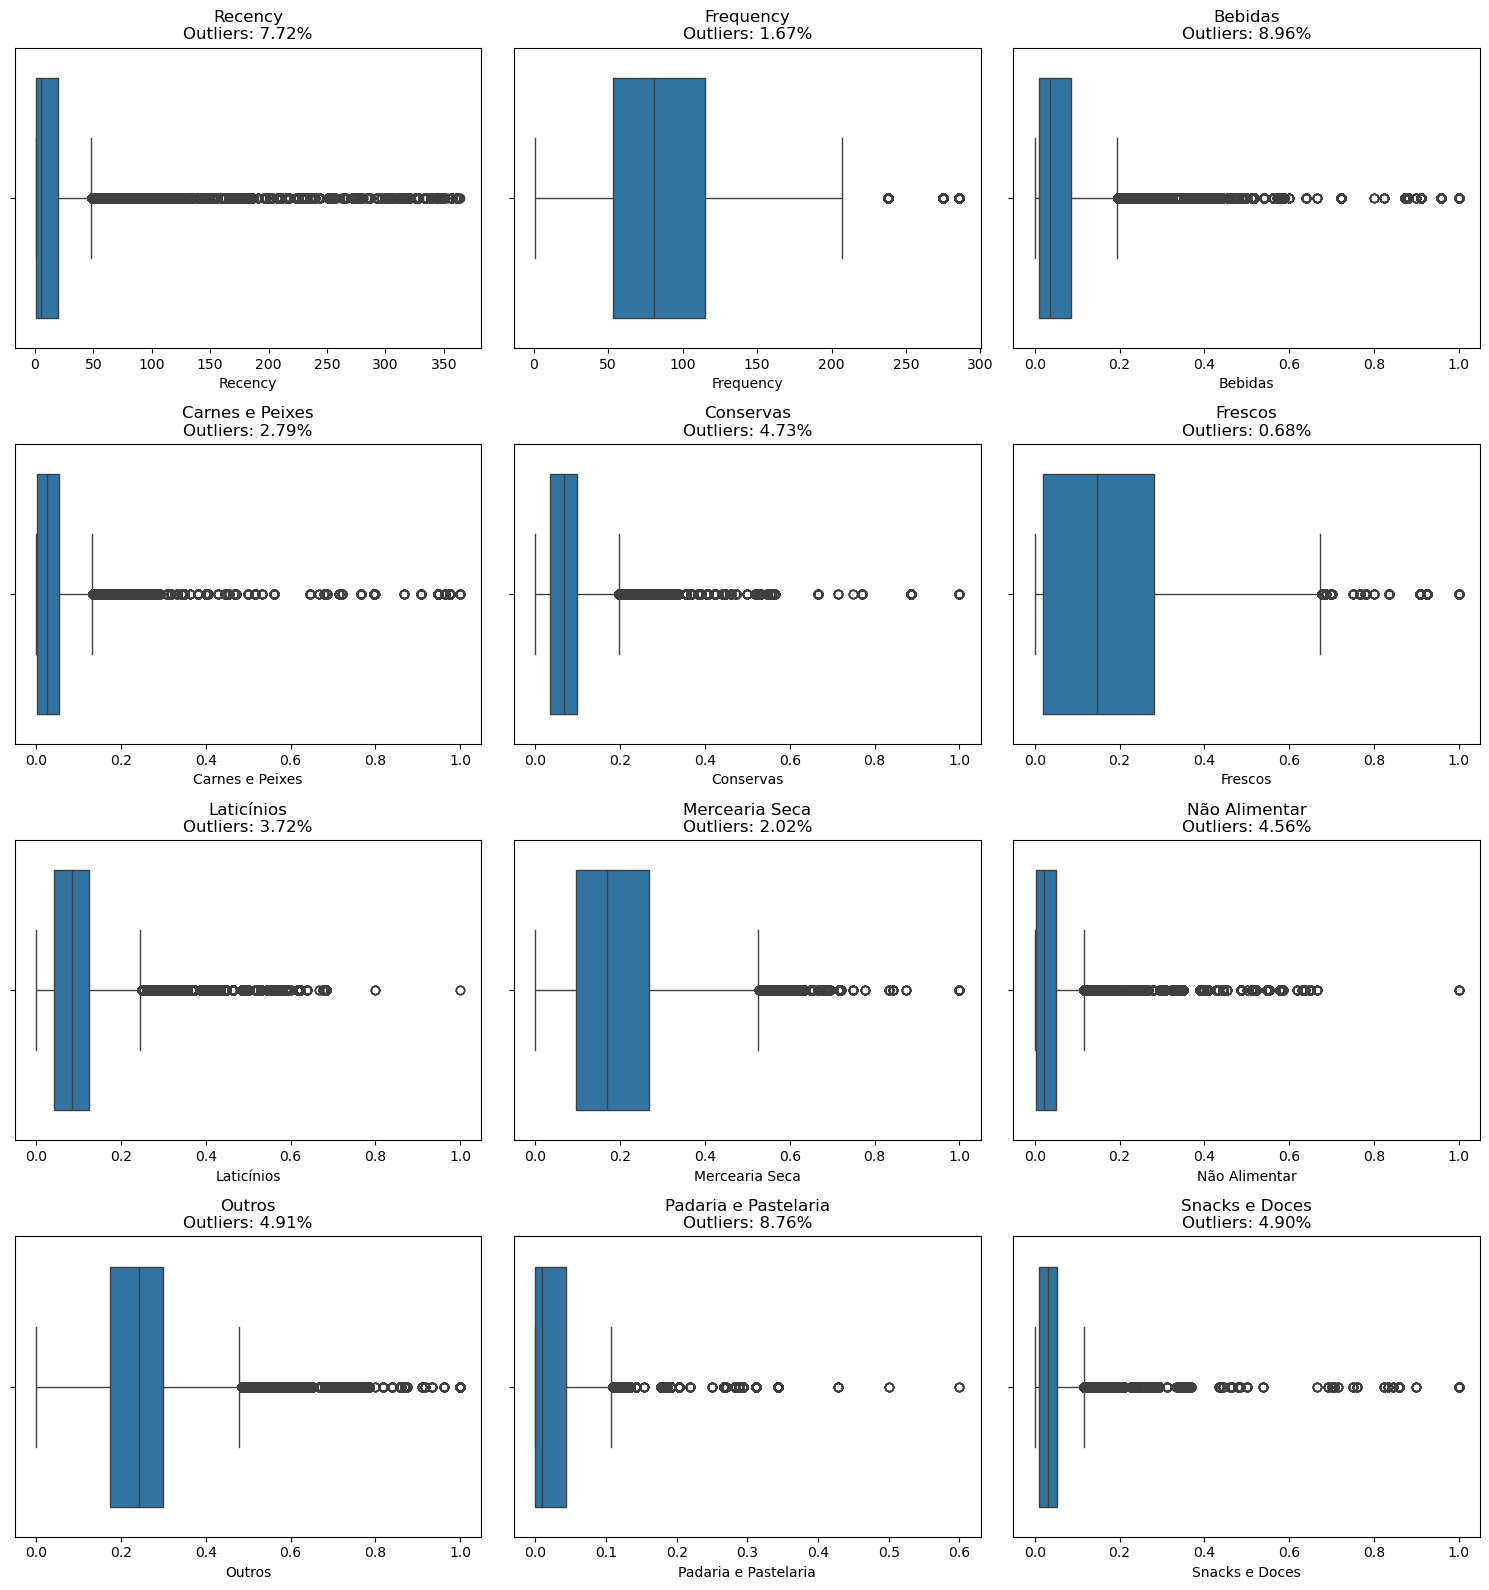

In [27]:
numeric_cols = [
    'Recency', 'Frequency',
    'Bebidas', 'Carnes e Peixes', 'Conservas', 'Frescos', 'Laticínios',
    'Mercearia Seca', 'Não Alimentar', 'Outros', 'Padaria e Pastelaria', 'Snacks e Doces'
]

n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols, 1):
    Q1 = test_data[col].quantile(0.25)
    Q3 = test_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((test_data[col] < lower) | (test_data[col] > upper)).sum()
    total = test_data.shape[0]
    outlier_pct = (outliers / total) * 100

    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=test_data[col])
    plt.title(f'{col}\nOutliers: {outlier_pct:.2f}%')
    plt.tight_layout()

plt.show()

Outlier Treatment

In [28]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in numeric_cols:
    test_data = remove_outliers_iqr(test_data, col)

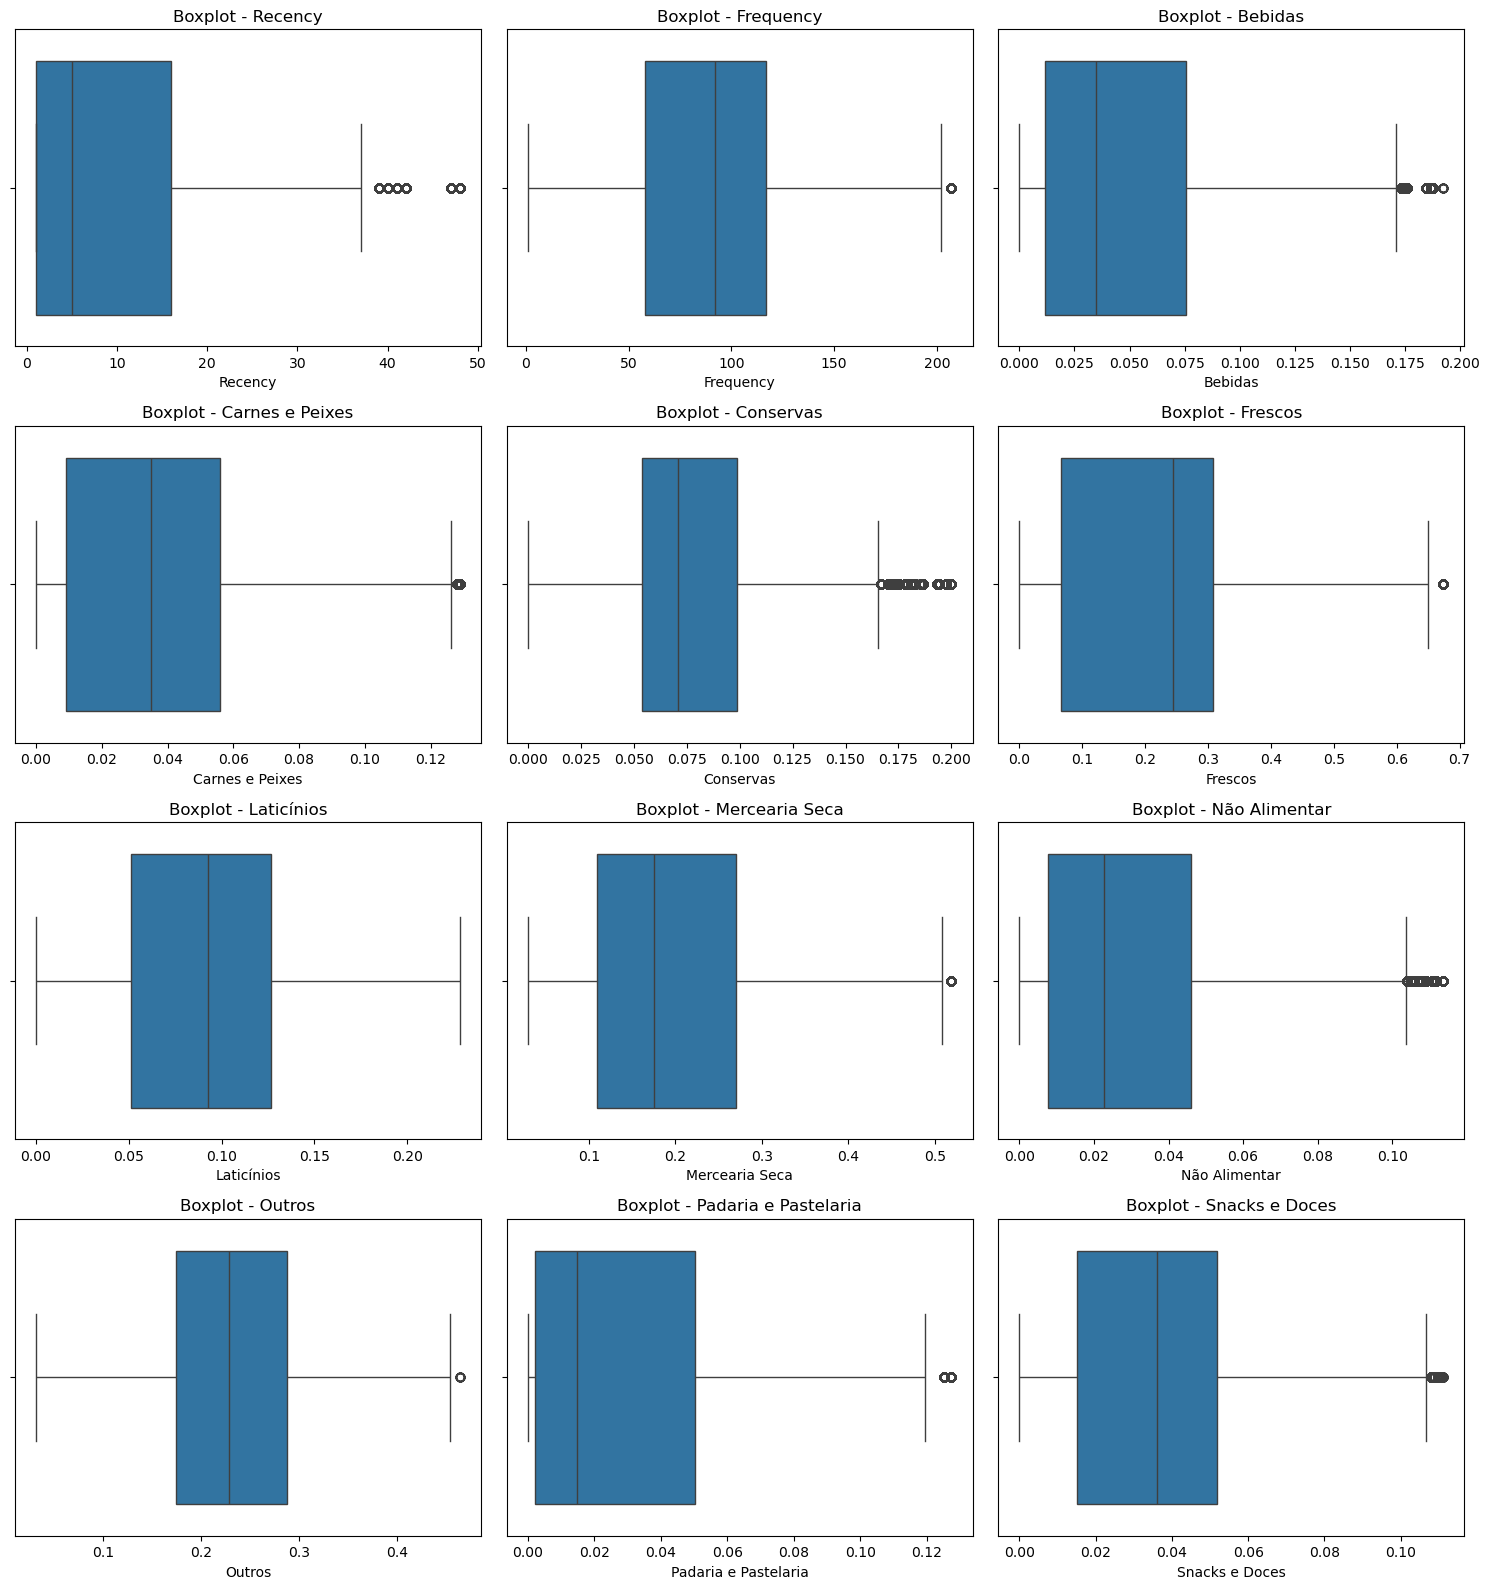

In [29]:
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=test_data[col])
    plt.title(f'Boxplot - {col}')
    plt.tight_layout()

plt.show()

Log Transformation on RFM

In [30]:
rfm_data = test_data.drop_duplicates('Client ID')[['Client ID', 'Recency', 'Frequency', 'Monetary']].copy()

rfm_data['Log_Recency'] = np.log1p(rfm_data['Recency'])
rfm_data['Log_Frequency'] = np.log1p(rfm_data['Frequency'])
rfm_data['Log_Monetary'] = np.log1p(rfm_data['Monetary'])

test_data = test_data.merge(rfm_data[['Client ID', 'Log_Recency', 'Log_Frequency', 'Log_Monetary']], on='Client ID', how='left')

print(test_data[['Client ID', 'Recency', 'Log_Recency', 'Frequency', 'Log_Frequency', 'Monetary', 'Log_Monetary']].head())

   Client ID  Recency  Log_Recency  Frequency  Log_Frequency  Monetary  \
0  210100281        1     0.693147        106       4.672829      2338   
1  210100281        1     0.693147        106       4.672829      2338   
2  210100281        1     0.693147        106       4.672829      2338   
3  210100281        1     0.693147        106       4.672829      2338   
4  210100281        1     0.693147        106       4.672829      2338   

   Log_Monetary  
0      7.757479  
1      7.757479  
2      7.757479  
3      7.757479  
4      7.757479  


Correlation Matrix

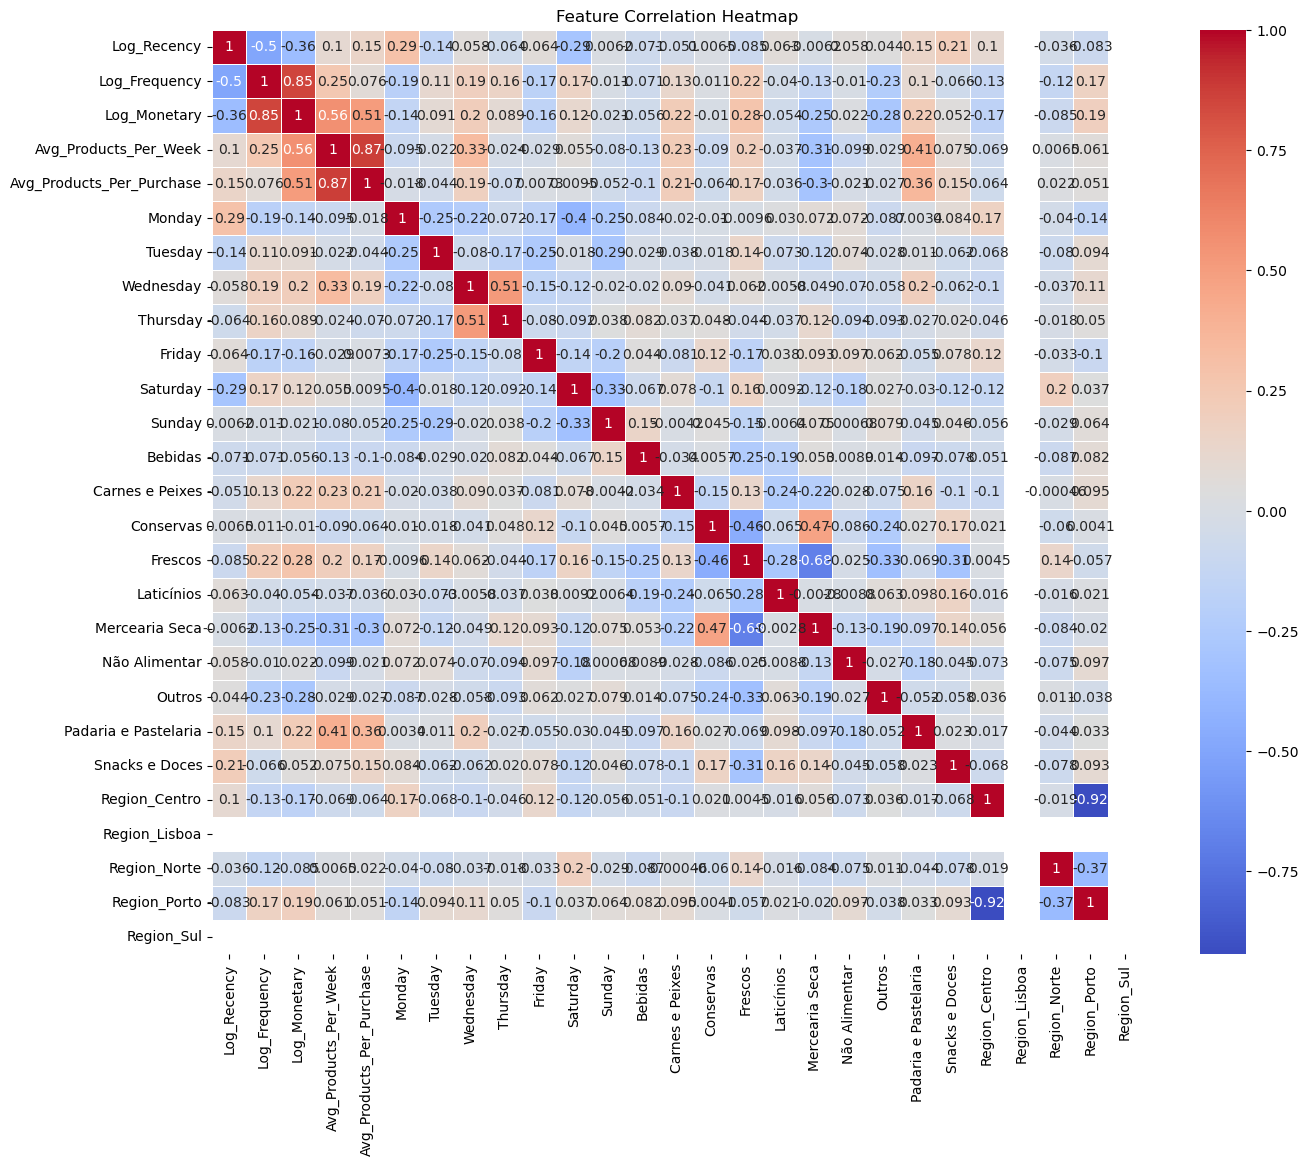

In [31]:
features = ['Log_Recency', 'Log_Frequency', 'Log_Monetary', 'Avg_Products_Per_Week', 'Avg_Products_Per_Purchase',
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
            'Bebidas', 'Carnes e Peixes', 'Conservas', 'Frescos', 'Laticínios', 'Mercearia Seca', 
            'Não Alimentar', 'Outros', 'Padaria e Pastelaria', 'Snacks e Doces',
            'Region_Centro', 'Region_Lisboa', 'Region_Norte', 'Region_Porto', 'Region_Sul']

corr_data = test_data.drop_duplicates('Client ID')[features]
corr_matrix = corr_data.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

### 🔍 Feature Selection for Clustering – Correlation-Based Justification

To ensure the quality and efficiency of clustering, we analyzed the correlation matrix of all candidate features. Based on this analysis and the clustering objective (behavioral segmentation of clients), we made the following decisions:

---

#### 📉 1. **Removed due to near-zero variance**
- `Region_Lisboa`, `Region_Sul`: These dummy variables had zero variance (all values were 0), indicating that none of the clients in the dataset belonged to these regions.
- `Thursday`: Extremely low variance; it contributes no meaningful differentiation between clients. ---------------------

---

#### 🔁 2. **Removed due to high correlation**
- `Log_Recency`, `Log_Monetary`: Both are highly correlated with `Log_Frequency` (`r ≈ 0.85`). We retained only `Log_Frequency`, as it best represents the customer's overall engagement.
- `Avg_Products_Per_Week`: Strongly correlated with `Avg_Products_Per_Purchase` (`r ≈ 0.87`). We chose to keep the latter for interpretability and clearer business meaning.
- `Region_Porto`: Strong inverse correlation with `Region_Centro` (`r ≈ -0.92`). We retained only `Region_Centro` to avoid redundancy in geographical information.

---

#### ⚠️ 3. **Removed for being redundant or raw identifiers**
- `Client ID`: Identifiers are not useful for clustering and should be removed before model training. ------------------
- Any raw or transformed columns that were previously used to create derived features (e.g., `Recency`, `Monetary`, `Macro_Category`, etc.).

---

### ✅ Final Feature Set for Clustering Includes:
- `Log_Frequency`
- `Avg_Products_Per_Purchase`
- Weekly distribution (`Monday` to `Sunday`)
- Macro category purchase ratios (`Frescos`, `Mercearia Seca`, `Snacks e Doces`, etc.)
- Active region dummies (e.g., `Region_Centro`, `Region_Norte`)

Drop Unnecessary Columns

In [32]:
cols_to_drop = [
    'Date', 'ID Product', 'YearMonth', 'ZIP Code', 'ID Client Type',
    'Product Description', 'ID Product Category', 'Recency', 'Monetary', 'Frequency',
    'Weekday', 'YearWeek', 'Region', 'Macro_Category',
    'Log_Recency', 'Log_Monetary', 'Avg_Products_Per_Week',
    'Region_Porto', 'Region_Lisboa', 'Region_Sul'
]

test_data = test_data.drop(columns=cols_to_drop)

In [33]:
test_data.var().sort_values()

Thursday                     2.603722e-04
Snacks e Doces               6.820910e-04
Não Alimentar                7.280302e-04
Carnes e Peixes              8.534254e-04
Padaria e Pastelaria         1.151487e-03
Region_Norte                 1.231731e-03
Conservas                    1.717060e-03
Bebidas                      1.735461e-03
Laticínios                   2.366152e-03
Outros                       6.224121e-03
Mercearia Seca               1.140576e-02
Frescos                      2.462707e-02
Region_Centro                2.485980e-02
Friday                       2.738710e-02
Wednesday                    3.762742e-02
Tuesday                      4.455887e-02
Sunday                       5.384456e-02
Monday                       6.098161e-02
Saturday                     6.236245e-02
Log_Frequency                2.931011e-01
Avg_Products_Per_Purchase    7.641840e+02
Client ID                    2.774342e+07
dtype: float64

In [34]:
data = test_data
data.columns

Index(['Client ID', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'Avg_Products_Per_Purchase', 'Region_Centro',
       'Region_Norte', 'Bebidas', 'Carnes e Peixes', 'Conservas', 'Frescos',
       'Laticínios', 'Mercearia Seca', 'Não Alimentar', 'Outros',
       'Padaria e Pastelaria', 'Snacks e Doces', 'Log_Frequency'],
      dtype='object')

In [35]:
data

,Client ID,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Avg_Products_Per_Purchase,Region_Centro,...,Carnes e Peixes,Conservas,Frescos,Laticínios,Mercearia Seca,Não Alimentar,Outros,Padaria e Pastelaria,Snacks e Doces,Log_Frequency
0,210100281,0.000000,0.408041,0.070145,0.00941,0.00000,0.413174,0.099230,22.056604,0,...,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428,4.672829
1,210100281,0.000000,0.408041,0.070145,0.00941,0.00000,0.413174,0.099230,22.056604,0,...,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428,4.672829
2,210100281,0.000000,0.408041,0.070145,0.00941,0.00000,0.413174,0.099230,22.056604,0,...,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428,4.672829
3,210100281,0.000000,0.408041,0.070145,0.00941,0.00000,0.413174,0.099230,22.056604,0,...,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428,4.672829
4,210100281,0.000000,0.408041,0.070145,0.00941,0.00000,0.413174,0.099230,22.056604,0,...,0.004705,0.124465,0.376390,0.034217,0.328486,0.000000,0.124893,0.000000,0.000428,4.672829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513273,210106386,0.000000,0.811765,0.000000,0.00000,0.00000,0.188235,0.000000,24.285714,0,...,0.041176,0.094118,0.147059,0.052941,0.229412,0.047059,0.300000,0.011765,0.011765,2.079442
513274,210106386,0.000000,0.811765,0.000000,0.00000,0.00000,0.188235,0.000000,24.285714,0,...,0.041176,0.094118,0.147059,0.052941,0.229412,0.047059,0.300000,0.011765,0.011765,2.079442
513275,210199916,0.024356,0.052888,0.013222,0.00000,0.74739,0.100905,0.061239,16.517241,0,...,0.050104,0.178149,0.052192,0.096033,0.171886,0.000000,0.351427,0.000000,0.043145,4.477337
513276,210199916,0.024356,0.052888,0.013222,0.00000,0.74739,0.100905,0.061239,16.517241,0,...,0.050104,0.178149,0.052192,0.096033,0.171886,0.000000,0.351427,0.000000,0.043145,4.477337


# **CLUSTERING**

Choosing Scaller

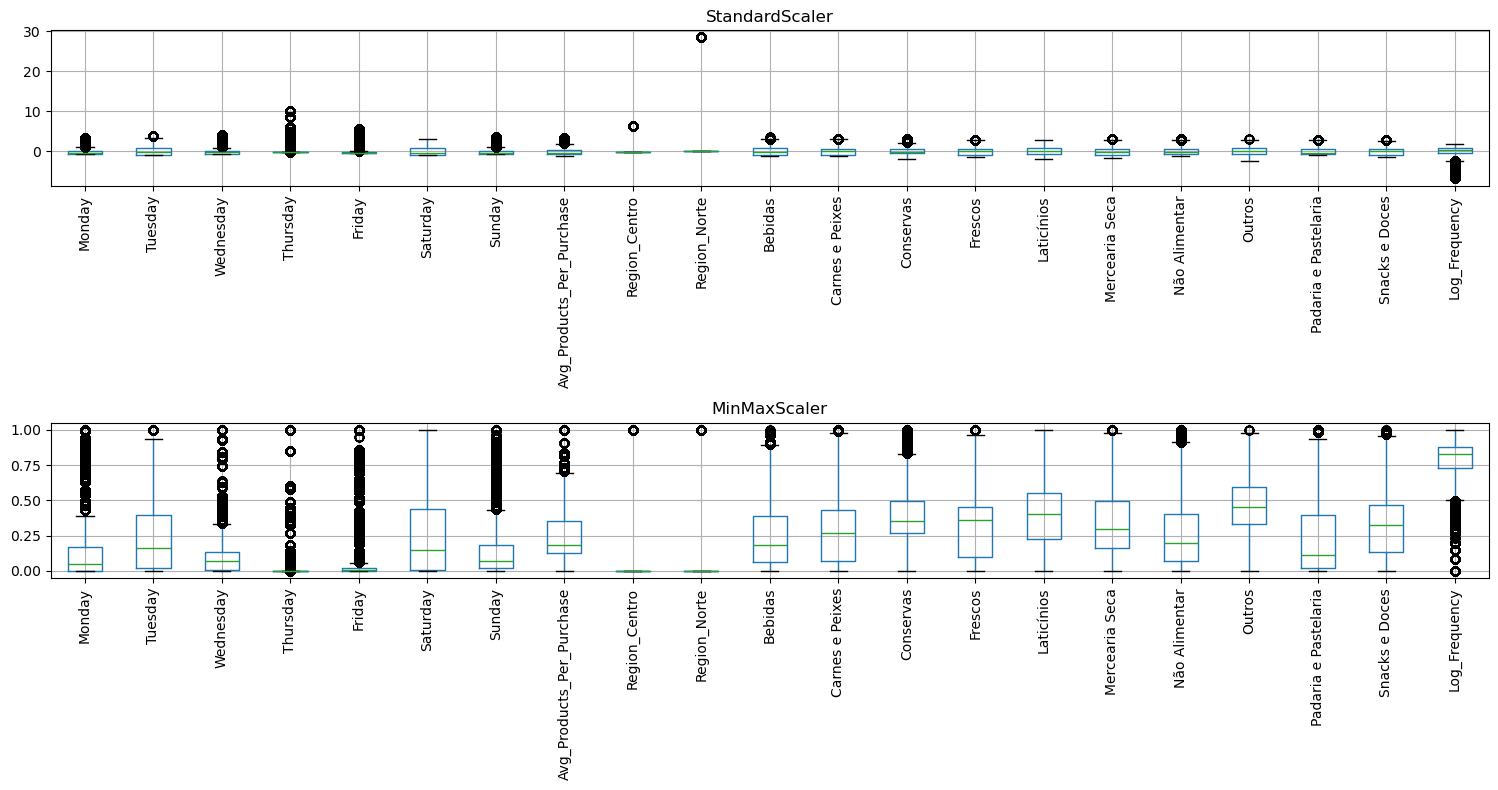

In [36]:
client_ids = data['Client ID']
features_to_scale = data.drop(columns=['Client ID'])

standard_scaler = StandardScaler()
standard_scaled = standard_scaler.fit_transform(features_to_scale)
standard_scaled_df = pd.DataFrame(standard_scaled, columns=features_to_scale.columns)

minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(features_to_scale)
minmax_scaled_df = pd.DataFrame(minmax_scaled, columns=features_to_scale.columns)

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

standard_scaled_df.boxplot(ax=axes[0], rot=90)
axes[0].set_title('StandardScaler')

minmax_scaled_df.boxplot(ax=axes[1], rot=90)
axes[1].set_title('MinMaxScaler')

plt.tight_layout()
plt.show()

Applying Standard Scaler

In [37]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
scaled_df['Client ID'] = client_ids.values

print(scaled_df.head())

    Monday  Tuesday  Wednesday  Thursday    Friday  Saturday    Sunday  \
0 -0.65448  0.88391  -0.298851  0.334427 -0.432269  0.692754 -0.318265   
1 -0.65448  0.88391  -0.298851  0.334427 -0.432269  0.692754 -0.318265   
2 -0.65448  0.88391  -0.298851  0.334427 -0.432269  0.692754 -0.318265   
3 -0.65448  0.88391  -0.298851  0.334427 -0.432269  0.692754 -0.318265   
4 -0.65448  0.88391  -0.298851  0.334427 -0.432269  0.692754 -0.318265   

   Avg_Products_Per_Purchase  Region_Centro  Region_Norte  ...  Conservas  \
0                  -0.481718      -0.161797     -0.035139  ...   1.145444   
1                  -0.481718      -0.161797     -0.035139  ...   1.145444   
2                  -0.481718      -0.161797     -0.035139  ...   1.145444   
3                  -0.481718      -0.161797     -0.035139  ...   1.145444   
4                  -0.481718      -0.161797     -0.035139  ...   1.145444   

    Frescos  Laticínios  Mercearia Seca  Não Alimentar    Outros  \
0  1.004321   -1.145334 

Cumulative Explained Variance per PC

In [38]:
features_for_pca = scaled_df.drop(columns=['Client ID'])
pca = PCA(n_components=None)
pca_components = pca.fit_transform(features_for_pca)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

for i, cumulative in enumerate(cumulative_variance):
    print(f'Component {i+1}: {cumulative:.4f}')

Component 1: 0.1566
Component 2: 0.2769
Component 3: 0.3663
Component 4: 0.4384
Component 5: 0.5048
Component 6: 0.5595
Component 7: 0.6119
Component 8: 0.6624
Component 9: 0.7068
Component 10: 0.7498
Component 11: 0.7909
Component 12: 0.8281
Component 13: 0.8625
Component 14: 0.8955
Component 15: 0.9244
Component 16: 0.9503
Component 17: 0.9692
Component 18: 0.9869
Component 19: 1.0000
Component 20: 1.0000
Component 21: 1.0000


Top features per PC

In [39]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
    index=features_for_pca.columns
)

for pc in loadings.columns:
    print(f"\nTop features for {pc}:")
    top_features = loadings[pc].abs().sort_values(ascending=False).head(3)
    for feature, weight in top_features.items():
        print(f"  {feature}: {weight:.4f}")


Top features for PC1:
  Mercearia Seca: 0.4211
  Avg_Products_Per_Purchase: 0.4179
  Padaria e Pastelaria: 0.3471

Top features for PC2:
  Frescos: 0.3966
  Snacks e Doces: 0.3585
  Tuesday: 0.3535

Top features for PC3:
  Monday: 0.3866
  Não Alimentar: 0.3780
  Thursday: 0.3370

Top features for PC4:
  Saturday: 0.5044
  Thursday: 0.4252
  Sunday: 0.3231

Top features for PC5:
  Outros: 0.5133
  Sunday: 0.4649
  Monday: 0.4131

Top features for PC6:
  Friday: 0.4479
  Thursday: 0.4103
  Tuesday: 0.3481

Top features for PC7:
  Region_Norte: 0.7522
  Friday: 0.4056
  Log_Frequency: 0.3462

Top features for PC8:
  Region_Centro: 0.6080
  Laticínios: 0.3829
  Não Alimentar: 0.3580

Top features for PC9:
  Friday: 0.5286
  Region_Centro: 0.4715
  Outros: 0.3335

Top features for PC10:
  Snacks e Doces: 0.4583
  Sunday: 0.4115
  Carnes e Peixes: 0.3805

Top features for PC11:
  Region_Norte: 0.4358
  Tuesday: 0.4333
  Saturday: 0.4303

Top features for PC12:
  Snacks e Doces: 0.3553
  Ou

Elbow Method

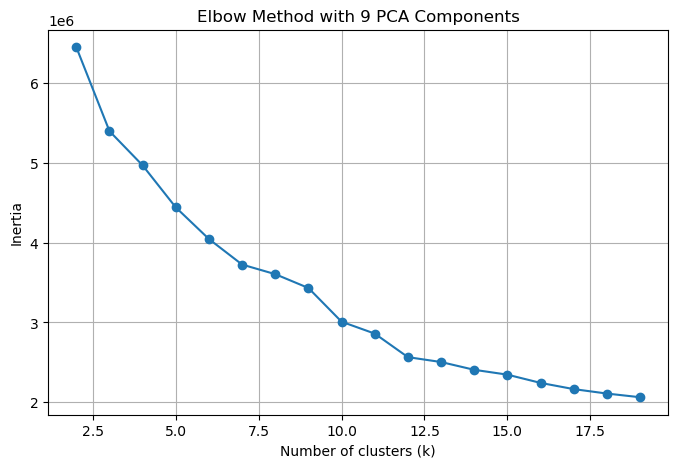

In [40]:
n_components_to_use = 9 
pca = PCA(n_components=n_components_to_use)
pca_selected_components = pca.fit_transform(scaled_features)
inertia = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_selected_components)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title(f'Elbow Method with {n_components_to_use} PCA Components')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

k = 5 or k = 6

In [41]:
"""from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
"""

"from sklearn.metrics import silhouette_score\n\nsilhouette_scores = []\nk_range = range(2, 20)\n\nfor k in k_range:\n    kmeans = KMeans(n_clusters=k, random_state=42)\n    labels = kmeans.fit_predict(pca_components)\n    score = silhouette_score(pca_components, labels)\n    silhouette_scores.append(score)\n\n# Plot Silhouette Scores\nplt.figure(figsize=(8,5))\nplt.plot(k_range, silhouette_scores, marker='o')\nplt.title('Silhouette Score')\nplt.xlabel('Number of clusters (k)')\nplt.ylabel('Silhouette Score')\nplt.grid(True)\nplt.show()\n"

K-Means

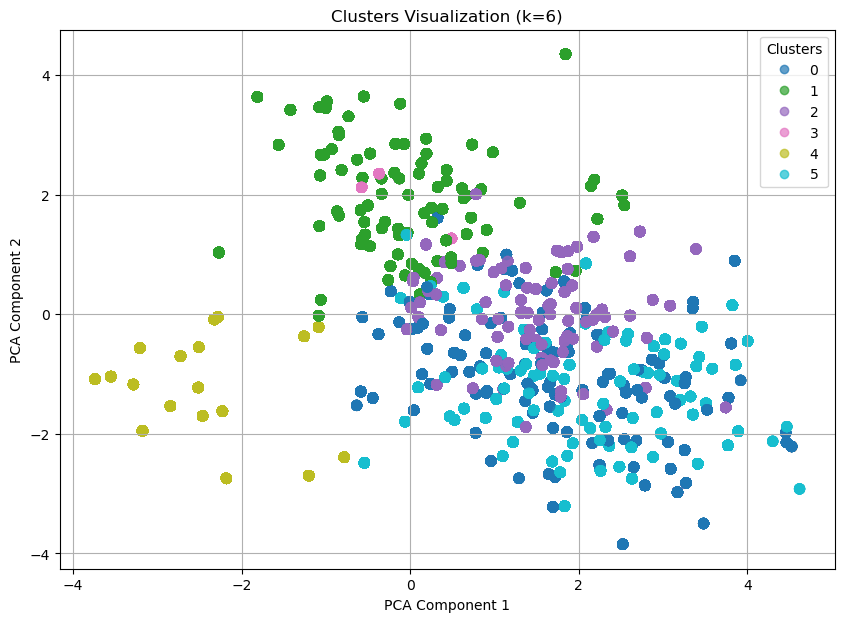

In [42]:
pca = PCA(n_components=9)
pca_selected_components = pca.fit_transform(scaled_features)
k_chosen = 6
kmeans = KMeans(n_clusters=k_chosen, random_state=42)
cluster_labels = kmeans.fit_predict(pca_selected_components)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_selected_components[:, 0], pca_selected_components[:, 1],
                      c=cluster_labels, cmap='tab10', s=50, alpha=0.7)

plt.title(f'Clusters Visualization (k={k_chosen})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

3D

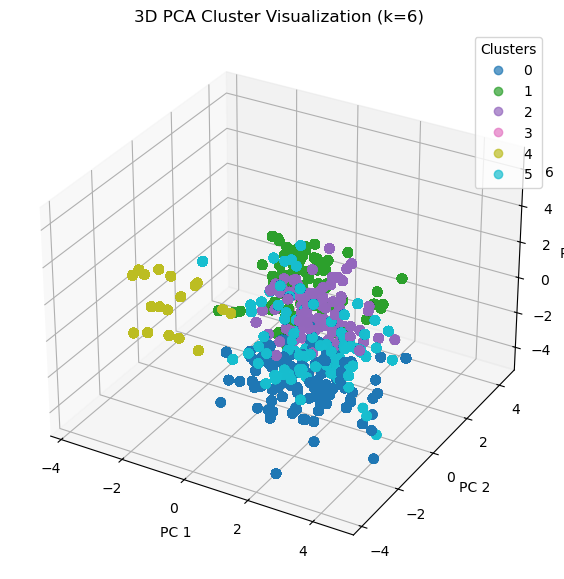

In [43]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(pca_selected_components)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], 
                     c=cluster_labels, cmap='tab10', s=40, alpha=0.7)

ax.set_title(f'3D PCA Cluster Visualization (k={k_chosen})')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

UMAP

In [101]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer.fit_transform(pca_selected_components) 

plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
                      c=cluster_labels, cmap='tab10', s=50, alpha=0.7)

plt.title(f'UMAP Projection of Clusters (k={k_chosen})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

c:\Users\gonca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


: 

DBSCAN

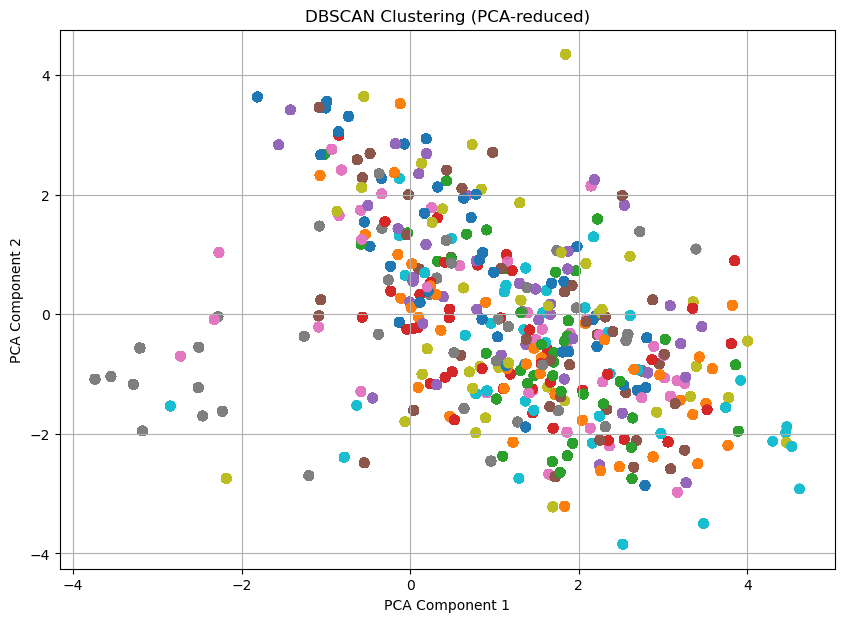

Estimated clusters: 397
Outliers detected: 9


In [45]:
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(pca_selected_components)

dbscan = DBSCAN(eps=0.5, min_samples=10)
db_labels = dbscan.fit_predict(pca_selected_components)

plt.figure(figsize=(10, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=db_labels, cmap='tab10', s=40, alpha=0.7)
plt.title('DBSCAN Clustering (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"Estimated clusters: {n_clusters}")
print(f"Outliers detected: {n_noise}")

t-SNE

In [46]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(pca_selected_components)
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.7)
plt.title('t-SNE Cluster Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\gonca\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gonca\AppData\Local\Temp\ipykernel_4740\1063301907.py", line 1, in <module>
    X_tsne = TSNE(n_components=2, random_state=42).fit_transform(pca_selected_components)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gonca\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py", line 1136, in fit_transform
    embedding = self._fit(X)
    